# Multi-Class Classification MLP

MLP neural network with multi-class classification. 

We are going to see if we can create a fully connected neural network that can classify an individual as a healthy control or as a subject diagnosed with one of 3 neuropsychiatric disorders, based on the shape (LB spectrum) of their white matter tracts.

The data set we will use contains individuals that have been diagnosed with bipolar disorder, ADHD, and schizophrenia. 

### Import the needed libraries

In [1]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1, l2, l1_l2

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import the data

In [2]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
allgroups_ev_dict = pickle.load(open("allgroups_ev_dict.p",'rb'))
# list of tracts we want to use
all_tracts = pickle.load(open('all_tracts.p','rb'))
# subject list
allsubjs = pickle.load(open('allsubjs.p','rb'))
# list of subject group 0 = control, 1 = adhd, 2 = bipolar, 3 = schizophrenia
groupid = pickle.load(open('groupid.p','rb'))

Since this is a different dataset from the binary classification, let's take a look at the data.

In [3]:
print len(all_tracts)
all_tracts[0:5]

20


[u'Callosum_Forceps_Major_surf',
 u'Callosum_Forceps_Minor_surf',
 u'Left_Arcuate_surf',
 u'Left_Cingulum_Cingulate_surf',
 u'Left_Cingulum_Hippocampus_surf']

We only have 20 tracts for each subject.

158


(array([40.,  0.,  0., 37.,  0.,  0., 43.,  0.,  0., 38.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

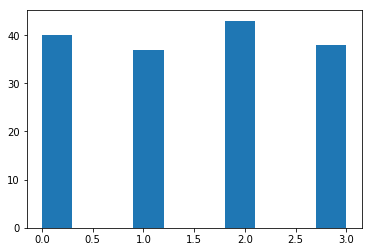

In [4]:
%matplotlib inline
print len(allsubjs)
plt.hist(groupid)

We have 158 subject in total. We have around 40 samples (individuals) in each group. The original dataset of the control group had over 100, we have randomly chosen 40 to keep the group sizes similar. 0 is controls, 1 is ADHD, 2 is bipolar, and 3 is schizophrenia

In [5]:
allgroups_ev_dict[all_tracts[0]].shape

(158, 600)

We have 600 eigenvalues per tract. 

## Preprocess the data

The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a single vector per subject.

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's StandardScaler function.



### Normalize the data

In [6]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict

In [7]:
# normalize all of the tracts so that each ev is centered on 0.
allgroups_ev_dict_scaled = scale_ev_dict(allgroups_ev_dict)

### Reorganize the data

Currently the data is a dictionary of 2D matrices, we want to reorganize this into a single 2D matrix with the shape `(158, n * 20)`, where 158 is the number of subjects and n is the number of eigenvalues we are using. It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary. We will start with just 200 eigenvalues for all tracts.

In [8]:
# change the organization to be one vector per subject with all evs for all tracts
def reorganize_spectrums(ev_dict_scaled, numev, HCP_subj_list=allsubjs, tractstouse=all_tracts):
    # create an empty numpy array of the shape we want
    # numev is the number of eigenvalues we want per tract
    allsubjs_alltracts_scaled = np.zeros([len(HCP_subj_list), numev*len(tractstouse)])
    for i in range(len(tractstouse)):
        allsubjs_alltracts_scaled[:, i*numev:i*numev+numev] = ev_dict_scaled[tractstouse[i]][:, 0:numev]
    return allsubjs_alltracts_scaled

In [9]:
allgroups_ev_dict_scaled_alltracts = reorganize_spectrums(allgroups_ev_dict_scaled, 200)

In [10]:
allgroups_ev_dict_scaled_alltracts.shape

(158, 4000)

### One hot encode the labels

Right now the labels are integers, we need to change them so they are one-hot encoded. This time we will use Keras bult-in function.

In [11]:
print groupid[0:5]

[0, 0, 0, 0, 0]


In [12]:
groupid_one = to_categorical(groupid)

In [13]:
print groupid_one[0:5]

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### Check datatype

In [14]:
groupid_one = groupid_one.astype('float32')
allgroups_ev_dict_scaled_alltracts = allgroups_ev_dict_scaled_alltracts.astype('float32')

### Split the data

This is a *very* small dataset, so it will likely not do well if we split the data into the three training/validation/testing sets. Since the dataset is so small and we are not even sure if a neural network will work, we are going to just split the data into two sets, a training set and a validation set. 

In [15]:
X = allgroups_ev_dict_scaled_alltracts
Y = groupid_one

#first split the training/validation data from the testing data
trainX, testX, trainY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainX) 
print len(testX)

126
32


In [16]:
#print the sum of each column in the one hot encoded labels
np.sum(testY, axis=0)

array([7., 9., 8., 8.], dtype=float32)

It is important to note that the train_test_split function will shuffle the data for you. In the testing dataset we have a fairly even distribution of classes.

We now have a training set and a validation set of data and we are ready to try classification with a MLP. Given that we have 4 categories of labels and roughly even amounts of samples for each label, by chance we should get ~25% correct. Our goal is to get a classification accuracy higher than chance. 

### Visually examine the data

Before setting up the MLP, lets take a look at the distribution of that data. We are going to first apply a PCA and plot the first two PC's of the data to see if there is a lot or a little overlap between the 4 groups.

In [25]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2)
pcapts = pca.fit_transform(allgroups_ev_dict_scaled_alltracts)

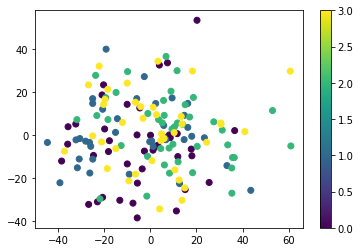

In [36]:
plt.scatter(pcapts[:,0], pcapts[:,1], c = groupid)
plt.colorbar()

Based on the PCA, there is a lot of overlap between the 4 groups. However it does seem that the ADHD group (blue) gathers in the lower left aand does not overlap as much with the other two disorders. Let's try an LDA, which will find the axes that best separate the 4 groups to see if it is even possible to separate them. 

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [61]:
lda = LinearDiscriminantAnalysis()
ldapts = lda.fit_transform(allgroups_ev_dict_scaled_alltracts, groupid)

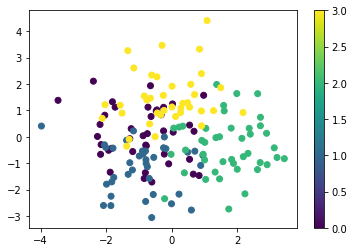

In [66]:
plt.scatter(ldapts[:,0], ldapts[:,1], c = groupid)
plt.colorbar()

We can see from the LDA that the groups are seperable, though there is a lot of overlap in the middle. We shouldn't expect very high accuracy, but we should be able to do above chance. The controls will likely do the worst.

## Set up the MLP

We are going to try a basic MLP. This will be the same model architecture we started with for the binary MLP, however, the last Dense layer will have 4 nodes (1 per category) and use the softmax activation function. We will also use the categorical_crossentropy loss function.

In [17]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

In [18]:
model = Sequential()
model.add(Dense(64, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = 20, batch_size = 1, validation_data=(testX, testY))


Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 1s 10ms/step - loss: 4.6192 - acc: 0.2857 - val_loss: 2.1872 - val_acc: 0.4375
Epoch 2/20
126/126 [==============================] - 0s 4ms/step - loss: 5.1071 - acc: 0.3413 - val_loss: 3.3367 - val_acc: 0.4375
Epoch 3/20
126/126 [==============================] - 0s 4ms/step - loss: 6.0963 - acc: 0.3016 - val_loss: 3.7780 - val_acc: 0.2812
Epoch 4/20
126/126 [==============================] - 0s 4ms/step - loss: 6.5673 - acc: 0.3730 - val_loss: 4.3806 - val_acc: 0.3438
Epoch 5/20
126/126 [==============================] - 0s 4ms/step - loss: 5.8608 - acc: 0.4127 - val_loss: 5.0970 - val_acc: 0.3750
Epoch 6/20
126/126 [==============================] - 0s 4ms/step - loss: 5.8398 - acc: 0.3968 - val_loss: 4.8568 - val_acc: 0.4062
Epoch 7/20
126/126 [==============================] - 0s 4ms/step - loss: 5.0957 - acc: 0.4286 - val_loss: 4.9015 - val_acc: 0.4062
Epoch 8/20
126/126 [==========

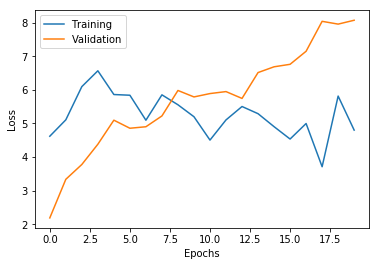

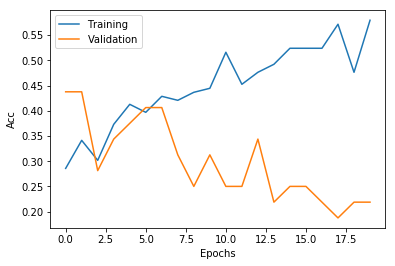

In [19]:
plot_history(history)

The highest accuracy obtained with a basic MLP was 43%, higher than chance. We can see that the model overfit very quickly, right after the 43% accuracy epoch. Let's add in some measures to prevent overfitting. We already have a few dropout layers, so we can adjust the learning rate of the optimizer (and also change the optimizer) and we can add in regularization.

In [19]:
# hidden_units = 64
# dropout_prop = 0.5
# optim = 'rmsprop'
# epochs = 20
# batch = 20
# reg=l1(0.01)
# plot=True
def make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot=False, verbose=1):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=reg))
    model.add(Dropout(dropout_prop))
    model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
    model.add(Dropout(dropout_prop))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(testX, testY), verbose=verbose)
    if plot:
        plot_history(history)
    return model

Let's try replacing the RMSprop optimizer with Adam. 

Train on 126 samples, validate on 32 samples
Epoch 1/20
126/126 [==============================] - 1s 9ms/step - loss: 11.6462 - acc: 0.2937 - val_loss: 9.4255 - val_acc: 0.3438
Epoch 2/20
126/126 [==============================] - 1s 5ms/step - loss: 11.4029 - acc: 0.3810 - val_loss: 9.0745 - val_acc: 0.3438
Epoch 3/20
126/126 [==============================] - 1s 5ms/step - loss: 12.1495 - acc: 0.3333 - val_loss: 10.4900 - val_acc: 0.3750
Epoch 4/20
126/126 [==============================] - 1s 5ms/step - loss: 12.3642 - acc: 0.3651 - val_loss: 11.5525 - val_acc: 0.3750
Epoch 5/20
126/126 [==============================] - 1s 4ms/step - loss: 12.6650 - acc: 0.3016 - val_loss: 10.7289 - val_acc: 0.3750
Epoch 6/20
126/126 [==============================] - 1s 5ms/step - loss: 11.1218 - acc: 0.3889 - val_loss: 10.1923 - val_acc: 0.2812
Epoch 7/20
126/126 [==============================] - 1s 5ms/step - loss: 11.2885 - acc: 0.3413 - val_loss: 9.6278 - val_acc: 0.3438
Epoch 8/20
126/126 [

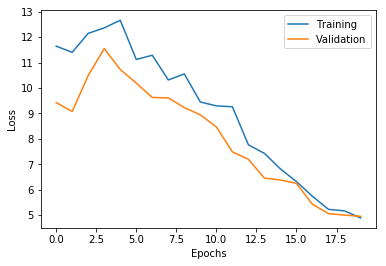

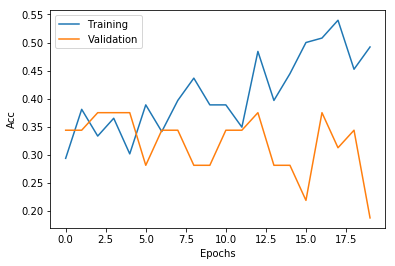

In [24]:
hidden_units = 64
dropout_prop = 0.5
optim = Adam(lr=0.001)
epochs = 20
batch = 1
reg=l1_l2(0.001)
plot=True
make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot)

Let's try increasing the hidden units

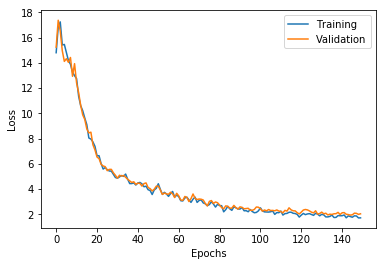

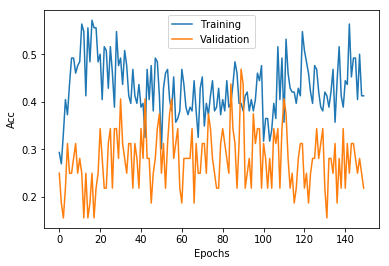

In [21]:
hidden_units = 100
dropout_prop = 0.5
optim = Adam(lr=0.001)
epochs = 150
batch = 1
reg=l1_l2(0.001)
plot=True
make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot, verbose=0)

Let's try reducing the dropout percentage

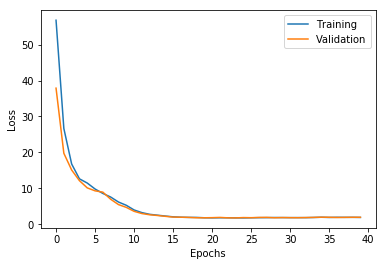

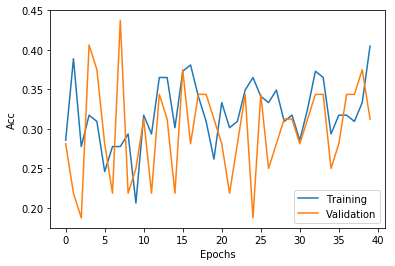

In [43]:
hidden_units = 100
dropout_prop = 0.2
optim = Adam(lr=0.001)
epochs = 40
batch = 1
reg=l1_l2(0.01)
plot=True
model = make_model(hidden_units, dropout_prop, optim, epochs, batch, reg, plot, verbose=0)

Ok we can see that one iteration reached about 43% accuracy, not really any better than before. Lets try saving down the best model and examine the results.

In [67]:
from keras.callbacks import ModelCheckpoint

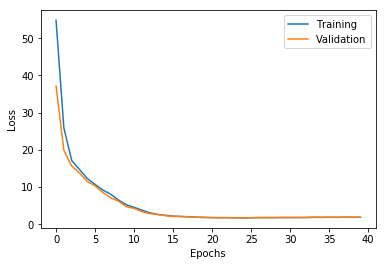

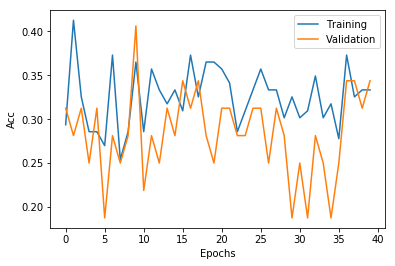

In [68]:
hidden_units = 100
dropout_prop = 0.2
optim = Adam(lr=0.001)
epochs = 40
batch = 1
reg=l1_l2(0.01)
plot=True
verbose=0
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_MC_MLP1.h5', monitor='val_acc', save_best_only=True)

model = Sequential()
model.add(Dense(hidden_units, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(testX, testY), verbose=verbose, callbacks=[best_model])
if plot:
    plot_history(history)

In [69]:
# load in the best model we saved down during training using the callback function
from keras.models import load_model
best_model1 = load_model('bestmodel_MC_MLP1.h5')

In [70]:
score = best_model1.evaluate(testX, testY)
print score

32/32 [==============================] - 0s 6ms/step
[4.764209747314453, 0.40625]


On this run of the model architecture the best model reached 40% accuracy. This is above chance. Let's take a closer look at what it is actually predicting. We will have the model predict the category of all subjects

In [71]:
pred = best_model2.predict(allgroups_ev_dict_scaled_alltracts)

The prediction function returns the softmax probabilities for each category so we will have to find the max category. 

In [72]:
pred[0:10]

array([[0.30692726, 0.2882289 , 0.17489201, 0.22995187],
       [0.2885691 , 0.27709538, 0.2256843 , 0.20865121],
       [0.25215432, 0.24850371, 0.25823164, 0.24111031],
       [0.2289525 , 0.19644931, 0.32671604, 0.24788211],
       [0.5260372 , 0.10960344, 0.15491757, 0.20944177],
       [0.41391158, 0.2701148 , 0.16345343, 0.15252021],
       [0.6655014 , 0.21996666, 0.06497833, 0.04955354],
       [0.30712503, 0.22760236, 0.2509545 , 0.2143181 ],
       [0.29471242, 0.20788059, 0.264799  , 0.23260796],
       [0.4299296 , 0.20118997, 0.16322528, 0.2056551 ]], dtype=float32)

In [73]:
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))

Let's plot the LDA again, but color it by the predicted classes

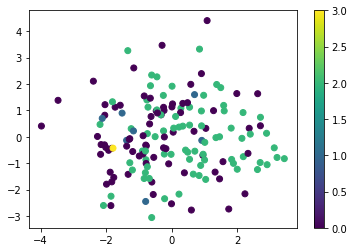

In [74]:
plt.scatter(ldapts[:,0], ldapts[:,1], c = pred_class)
plt.colorbar()

Right away we can see that it is mostly guessing just two categories. These are the control and bipolar categories which have a few more subjects than the other two. This slight imbalance may be a problem. 

(array([74.,  0.,  0.,  7.,  0.,  0., 76.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

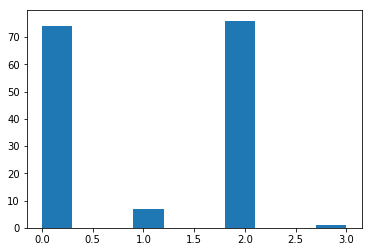

In [75]:
plt.hist(pred_class)

One thing we can try is to add weights to the class. Sklearn has a function that will calculate weights for each class to help with balancing the datasets.

In [77]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in trainY]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(class_weights)

[0.95454545 1.125      0.9        1.05      ]


The class_weights variable is added to the fit step of the model.

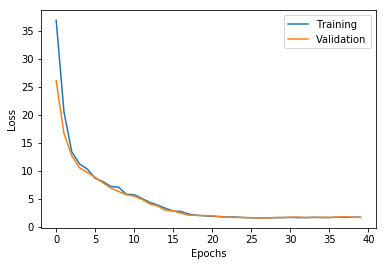

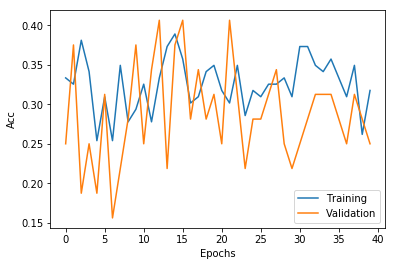

In [103]:
hidden_units = 64
dropout_prop = 0.2
optim = Adam(lr=0.001)
epochs = 40
batch = 1
reg=l1_l2(0.01)
plot=True
verbose=0
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_MC_MLP2.h5', monitor='val_acc', save_best_only=True)

model = Sequential()
model.add(Dense(hidden_units, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(testX, testY), verbose=verbose, callbacks=[best_model], class_weight=class_weights)
if plot:
    plot_history(history)

32/32 [==============================] - 0s 15ms/step
[4.1135125160217285, 0.40625]


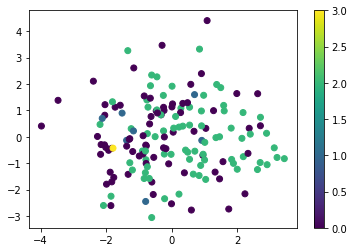

In [106]:
best_model2 = load_model('bestmodel_MC_MLP2.h5')
score = best_model2.evaluate(testX, testY)
print score
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))
plt.scatter(ldapts[:,0], ldapts[:,1], c = pred_class)
plt.colorbar()

(array([74.,  0.,  0.,  7.,  0.,  0., 76.,  0.,  0.,  1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

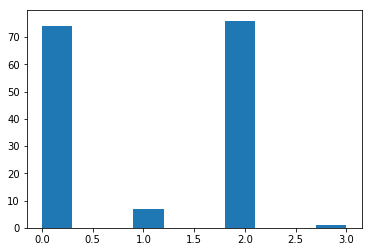

In [108]:
plt.hist(pred_class)

This did not seem to help the issue. It may be that bipolar disorder is the only class distinguishable from controls. 

We can also apply a PCA to the prediction probabilities to get an idea of how the model is representing the data. First let's plot it with the actual class colors. Then with the predicted class colors.

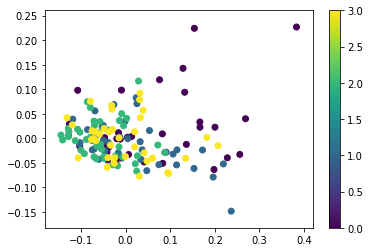

In [109]:
pca = PCA(n_components=2)
pts = pca.fit_transform(pred)
plt.scatter(pts[:,0], pts[:,1], c = groupid)
plt.colorbar()

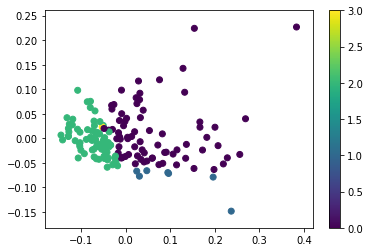

In [110]:
plt.scatter(pts[:,0], pts[:,1], c = pred_class)
plt.colorbar()

We can see that the model is creating a boundary for the control class, bipolar class and the schizophrenia class. Only one individual is predicted to have ADHD. 

The model is doing better than chance, but it is mainly only predicting two of the categories. Adding weights to the classes did not help. Let's try changing the architecture by adding another dense layer.

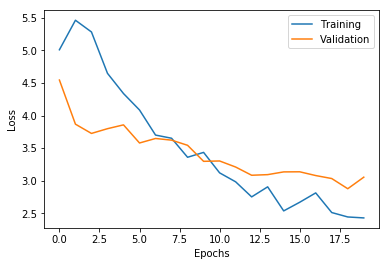

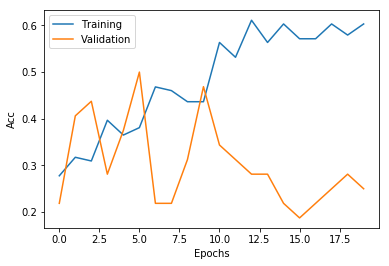

In [129]:
hidden_units = 64
dropout_prop = 0.3
optim = Adam(lr=0.001)
epochs = 20
batch = 1
reg=l2(0.01)
plot=True
verbose=0
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_MC_MLP4.h5', monitor='val_acc', save_best_only=True)

model = Sequential()
model.add(Dense(hidden_units, input_dim=allgroups_ev_dict_scaled_alltracts.shape[1], activation='relu', kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(hidden_units, activation='relu',kernel_regularizer=reg))
model.add(Dropout(dropout_prop))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs = epochs, batch_size = batch, validation_data=(testX, testY), verbose=verbose, callbacks=[best_model], class_weight=class_weights)
if plot:
    plot_history(history)

32/32 [==============================] - 1s 25ms/step
[3.578045129776001, 0.5]


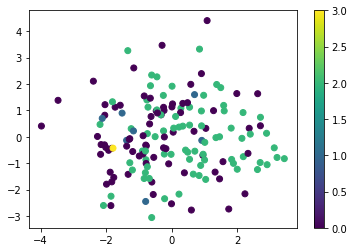

In [130]:
best_model4 = load_model('bestmodel_MC_MLP4.h5')
score = best_model4.evaluate(testX, testY)
print score
pred_class = []
for i in range(len(pred)):
    pred_class.append(np.argmax(pred[i]))
plt.scatter(ldapts[:,0], ldapts[:,1], c = pred_class)
plt.colorbar()

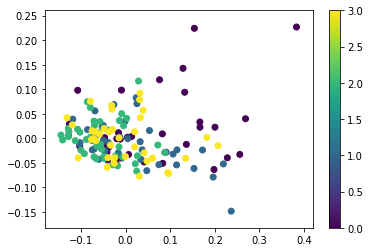

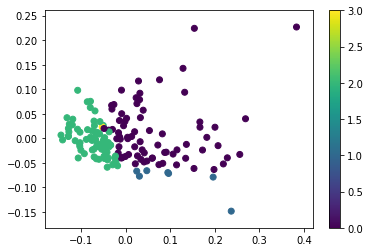

In [131]:
pca = PCA(n_components=2)
pts = pca.fit_transform(pred)
plt.scatter(pts[:,0], pts[:,1], c = groupid)
plt.colorbar()
plt.show()

plt.scatter(pts[:,0], pts[:,1], c = pred_class)
plt.colorbar()
plt.show()

With the additional layer the accuracy improved and we were able to reach 50% correctly classified. However, this seems to have just improved the classifcation boundary between the bipolar class and the control class. It does not seem to have affected the classification of the other two classes. 